In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from df_after_transform import df_after_transform
from sklearn import set_config
from sklearn.calibration import CalibrationDisplay
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    DetCurveDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    classification_report,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

set_config(display="diagram")  # display='text' is the default

pd.set_option(
    "display.max_colwidth", 1000, "display.max_rows", 50, "display.max_columns", None
)

In [2]:
import pandas_datareader as pdr
from datetime import datetime
import yfinance as yf

start = datetime(2020, 1, 1)
end = datetime(2023, 4, 1)

# load
sp500 = yf.download('^GSPC', start, end)

[*********************100%***********************]  1 of 1 completed


In [3]:
sp500 = sp500.transpose()
sp500=sp500[-2:-1]
sp500 = sp500.transpose()
sp500["Daily_RV"] = sp500["Adj Close"].pct_change()
sp500=sp500.iloc[:,-1:]
sp500=sp500.reset_index()
sp500["TomorrowMRV"] = sp500["Daily_RV"].shift(-1)  # Shift the return values up by 1 row
sp500

,Date,Daily_RV,TomorrowMRV
0,2020-01-02,NaN,-0.007060
1,2020-01-03,-0.007060,0.003533
2,2020-01-06,0.003533,-0.002803
3,2020-01-07,-0.002803,0.004902
4,2020-01-08,0.004902,0.006655
...,...,...,...
813,2023-03-27,0.001647,-0.001574
814,2023-03-28,-0.001574,0.014237
815,2023-03-29,0.014237,0.005715
816,2023-03-30,0.005715,0.014437


In [4]:
layoff=pd.read_csv('newdata.csv')
layoff=layoff.drop(['Unnamed: 0','Source','List_of_Employees_Laid_Off','Firm','Date_Added','Funds_Raised'], axis=1)
layoff

Company     Location_HQ        Industry  Laid_Off_Count  \
0             Opendoor     SF Bay Area     Real Estate           560.0   
1             Opendoor     SF Bay Area     Real Estate           550.0   
2             Opendoor     SF Bay Area     Real Estate           600.0   
3            Medtronic     SF Bay Area      Healthcare            59.0   
4               Redfin         Seattle     Real Estate           201.0   
..                 ...             ...             ...             ...   
365           CarGurus          Boston  Transportation           130.0   
366              GoPro     SF Bay Area        Consumer           200.0   
367               Domo  Salt Lake City            Data            90.0   
368  Sage Therapeutics          Boston      Healthcare           340.0   
369          Blackbaud      Charleston           Other           500.0   

     Percentage        Date     Stage        Country ticker  \
0          0.22  2023-04-18  Post-IPO  United States   OPEN   
1          0.18  2022-11-02  Post-IPO  United States   OPEN   
2          0.35  2020-04-15  Series E  United States   OPEN   
3           NaN  2023-04-12  Post-IPO  United States    MDT   
4          0.04  2023-04-11  Post-IPO  United States   RDFN   
..          ...         ...       ...            ...    ...   
365        0.13  2020-04-16  Post-IPO  United States   CARG   
366        0.20  2020-04-15  Post-IPO  United States   GPRO   
367        0.10  2020-04-09  Post-IPO  United States   DOMO   
368        0.53  2020-04-07  Post-IPO  United States   SAGE   
369        0.14         NaN  Post-IPO  United States   BLKB   

     2020-01-02 00:00:00  2020-01-03 00:00:00  2020-01-06 00:00:00  \
0                    NaN                  NaN                  NaN   
1                    NaN                  NaN                  NaN   
2                    NaN                  NaN                  NaN   
3             105.364609           104.739189           105.668121   
4              21.625000            21.610001            21.410000   
..                   ...                  ...                  ...   
365            36.509998            36.349998            36.380001   
366             4.400000             4.320000             4.470000   
367            21.040001            21.500000            22.690001   
368            73.160004            73.529999            75.400002   
369            80.756813            78.620338            79.269264   

     2020-01-07 00:00:00  2020-01-08 00:00:00  2020-01-09 00:00:00  \
0                    NaN                  NaN                  NaN   
1                    NaN                  NaN                  NaN   
2                    NaN                  NaN                  NaN   
3             105.300224           107.148880           108.887177   
4              21.469999            21.459999            21.709999   
..                   ...                  ...                  ...   
365            36.189999            36.430000            35.290001   
366             4.400000             4.420000             4.420000   
367            22.650000            22.610001            23.650000   
368            74.820000            75.639999            76.120003   
369            77.711830            77.981392            79.209358   

     2020-01-10 00:00:00  2020-01-13 00:00:00  2020-01-14 00:00:00  \
0                    NaN                  NaN                  NaN   
1                    NaN                  NaN                  NaN   
2                    NaN                  NaN                  NaN   
3             109.117111           108.537689           107.645538   
4              21.850000            22.250000            22.360001   
..                   ...                  ...                  ...   
365            35.180000            34.869999            35.450001   
366             4.270000             4.260000             4.150000   
367            24.190001            24.559999            

In [5]:
price = layoff.iloc[:, 8:]
price=price.drop_duplicates().reset_index().drop(['index'],axis=1)
price

ticker  2020-01-02 00:00:00  2020-01-03 00:00:00  2020-01-06 00:00:00  \
0     OPEN                  NaN                  NaN                  NaN   
1      MDT           105.364609           104.739189           105.668121   
2     RDFN            21.625000            21.610001            21.410000   
3     PEAR                  NaN                  NaN                  NaN   
4     AMPL                  NaN                  NaN                  NaN   
..     ...                  ...                  ...                  ...   
243   CARG            36.509998            36.349998            36.380001   
244   GPRO             4.400000             4.320000             4.470000   
245   DOMO            21.040001            21.500000            22.690001   
246   SAGE            73.160004            73.529999            75.400002   
247   BLKB            80.756813            78.620338            79.269264   

     2020-01-07 00:00:00  2020-01-08 00:00:00  2020-01-09 00:00:00  \
0                    NaN                  NaN                  NaN   
1             105.300224           107.148880           108.887177   
2              21.469999            21.459999            21.709999   
3                    NaN                  NaN                  NaN   
4                    NaN                  NaN                  NaN   
..                   ...                  ...                  ...   
243            36.189999            36.430000            35.290001   
244             4.400000             4.420000             4.420000   
245            22.650000            22.610001            23.650000   
246            74.820000            75.639999            76.120003   
247            77.711830            77.981392            79.209358   

     2020-01-10 00:00:00  2020-01-13 00:00:00  2020-01-14 00:00:00  \
0                    NaN                  NaN                  NaN   
1             109.117111           108.537689           107.645538   
2              21.850000            22.250000            22.360001   
3                    NaN                  NaN                  NaN   
4                    NaN                  NaN                  NaN   
..                   ...                  ...                  ...   
243            35.180000            34.869999            35.450001   
244             4.270000             4.260000             4.150000   
245            24.190001            24.559999            24.290001   
246            77.239998            74.769997            76.680000   
247            78.580399            80.427353            79.878265   

     2020-01-15 00:00:00  2020-01-16 00:00:00  2020-01-17 00:00:00  \
0                    NaN                  NaN                  NaN   
1             107.912285           109.319458           109.475815   
2              23.950001            24.219999            23.520000   
3                    NaN                  NaN                  NaN   
4                    NaN                  NaN                  NaN   
..                   ...                  ...                  ...   
243            36.009998            37.730000            38.060001   
244             4.240000             4.310000             4.290000   
245            24.910000            24.969999            24.110001   
246            74.910004            74.089996            76.400002   
247            79.828346            81.954834            81.645348   

     2020-01-21 00:00:00  2020-01-22 00:00:00  2020-01-23 00:00:00  \
0                    NaN                  NaN                  NaN   
1             110.662277           111.370453           111.260094   
2              24.049999            24.490000            24.950001   
3                    NaN                  NaN                  NaN   
4                    NaN                  NaN                  NaN   
..                   ...                  ...                  ...   
243            37.970001            37.000000            37.080002

In [6]:
# Melt the DataFrame
price_melted = pd.melt(price, id_vars=['ticker'], var_name='date', value_name='price')

price_melted['date'] = pd.to_datetime(price_melted['date'])

# Sort the DataFrame by the 'company' column
price_sorted = price_melted.sort_values(by=['ticker','date'])

price_sorted
dailyprice=price_sorted.reset_index().drop('index', axis=1)

In [7]:
dailyprice = dailyprice[dailyprice['ticker'] != 'ZY']
dailyprice["Daily_RV"] = dailyprice.groupby("ticker")["price"].pct_change()
dailyprice["Day Before Return"] = dailyprice.groupby('ticker')["Daily_RV"].shift(1)  # Shift the return values down by 1 row
dailyprice["Day After Return"] = dailyprice.groupby('ticker')["Daily_RV"].shift(-1)  # Shift the return values up by 1 row

dailyprice

,ticker,date,price,Daily_RV,Day Before Return,Day After Return
0,AAPL,2020-01-02,73.449394,NaN,NaN,-0.009722
1,AAPL,2020-01-03,72.735313,-0.009722,NaN,0.007968
2,AAPL,2020-01-06,73.314903,0.007968,-0.009722,-0.004703
3,AAPL,2020-01-07,72.970085,-0.004703,0.007968,0.016086
4,AAPL,2020-01-08,74.143890,0.016086,-0.004703,0.021241
...,...,...,...,...,...,...
202859,ZUO,2023-03-27,9.480000,0.018260,-0.015856,0.003165
202860,ZUO,2023-03-28,9.510000,0.003165,0.018260,0.000000
202861,ZUO,2023-03-29,9.510000,0.000000,0.003165,-0.023134
202862,ZUO,2023-03-30,9.290000,-0.023134,0.000000,0.063509


In [8]:
newlayoff=layoff.iloc[:,:9]
newlayoff = newlayoff.rename(columns={'Date': 'date'})
newlayoff['date'] = pd.to_datetime(newlayoff['date'])
newlayoff

,Company,Location_HQ,Industry,Laid_Off_Count,Percentage,date,Stage,Country,ticker
0,Opendoor,SF Bay Area,Real Estate,560.0,0.22,2023-04-18,Post-IPO,United States,OPEN
1,Opendoor,SF Bay Area,Real Estate,550.0,0.18,2022-11-02,Post-IPO,United States,OPEN
2,Opendoor,SF Bay Area,Real Estate,600.0,0.35,2020-04-15,Series E,United States,OPEN
3,Medtronic,SF Bay Area,Healthcare,59.0,NaN,2023-04-12,Post-IPO,United States,MDT
4,Redfin,Seattle,Real Estate,201.0,0.04,2023-04-11,Post-IPO,United States,RDFN
...,...,...,...,...,...,...,...,...,...
365,CarGurus,Boston,Transportation,130.0,0.13,2020-04-16,Post-IPO,United States,CARG
366,GoPro,SF Bay Area,Consumer,200.0,0.20,2020-04-15,Post-IPO,United States,GPRO
367,Domo,Salt Lake City,Data,90.0,0.10,2020-04-09,Post-IPO,United States,DOMO
368,Sage Therapeutics,Boston,Healthcare,340.0,0.53,2020-04-07,Post-IPO,United States,SAGE


In [9]:
date1=dailyprice.merge(newlayoff,on=['ticker','date'])
date1 = date1.rename(columns={'Daily_RV':'Daily Return Value today','Day Before Return': 'Daily Return Value yesterday','Day After Return':'Daily Return Value tomorrow'})
date1

,ticker,date,price,Daily Return Value today,Daily Return Value yesterday,Daily Return Value tomorrow,Company,Location_HQ,Industry,Laid_Off_Count,Percentage,Stage,Country
0,ABNB,2020-05-05,NaN,NaN,NaN,NaN,Airbnb,SF Bay Area,Travel,1900.0,0.25,Private Equity,United States
1,ABNB,2023-03-03,125.730003,0.027374,0.012828,0.004772,Airbnb,SF Bay Area,Travel,30.0,NaN,Post-IPO,United States
2,ABSI,2022-08-09,3.900000,0.007752,0.043127,0.076923,Absci,Vancouver,Healthcare,40.0,NaN,Post-IPO,United States
3,ACCD,2023-03-03,13.300000,0.075182,-0.001614,-0.035338,Accolade,Seattle,Healthcare,NaN,NaN,Post-IPO,United States
4,ADBE,2022-12-06,331.149994,-0.008800,-0.021784,-0.013498,Adobe,SF Bay Area,Marketing,100.0,NaN,Post-IPO,United States
...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,Z,2021-11-02,87.199997,-0.102419,-0.062530,-0.249197,Zillow,Seattle,Real Estate,2000.0,0.25,Post-IPO,United States
351,Z,2022-10-26,30.670000,-0.017302,0.071772,-0.001304,Zillow,Seattle,Real Estate,300.0,0.05,Post-IPO,United States
352,ZM,2023-02-07,84.660004,0.098482,-0.031054,-0.062722,Zoom,SF Bay Area,Other,1300.0,0.15,Post-IPO,United States
353,ZS,2023-03-02,134.130005,0.044301,-0.020663,-0.111012,Zscaler,SF Bay Area,Security,177.0,0.03,Post-IPO,United States


In [10]:
new=date1.merge(sp500,left_on='date',right_on='Date')
new=new.drop('Date',axis=1)
new=new.rename(columns={'Daily_RV':'Market Daily Return Value today','TomorrowMRV':'Market Daily Return Value tomorrow'})
new

,ticker,date,price,Daily Return Value today,Daily Return Value yesterday,Daily Return Value tomorrow,Company,Location_HQ,Industry,Laid_Off_Count,Percentage,Stage,Country,Market Daily Return Value today,Market Daily Return Value tomorrow
0,ABNB,2020-05-05,NaN,NaN,NaN,NaN,Airbnb,SF Bay Area,Travel,1900.0,0.25,Private Equity,United States,0.009041,-0.006979
1,ABNB,2023-03-03,125.730003,0.027374,0.012828,0.004772,Airbnb,SF Bay Area,Travel,30.0,NaN,Post-IPO,United States,0.016148,0.000687
2,ACCD,2023-03-03,13.300000,0.075182,-0.001614,-0.035338,Accolade,Seattle,Healthcare,NaN,NaN,Post-IPO,United States,0.016148,0.000687
3,EMBK,2023-03-03,3.810000,-0.045113,-0.029197,-0.328084,Embark Trucks,SF Bay Area,Transportation,230.0,0.70,Post-IPO,United States,0.016148,0.000687
4,ABSI,2022-08-09,3.900000,0.007752,0.043127,0.076923,Absci,Vancouver,Healthcare,40.0,NaN,Post-IPO,United States,-0.004249,0.021291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,WISH,2022-03-01,68.099998,-0.042194,0.044053,-0.057269,Wish,SF Bay Area,Retail,190.0,0.15,Post-IPO,United States,-0.015474,0.018643
351,XIACF,2022-12-19,1.400000,-0.007092,0.000000,-0.032143,Xiaomi,Beijing,Consumer,NaN,NaN,Post-IPO,United States,-0.009008,0.001037
352,YELP,2020-07-13,22.740000,-0.017711,0.037186,0.015391,Yelp,SF Bay Area,Consumer,63.0,NaN,Post-IPO,United States,-0.009363,0.013406
353,Z,2021-11-02,87.199997,-0.102419,-0.062530,-0.249197,Zillow,Seattle,Real Estate,2000.0,0.25,Post-IPO,United States,0.003680,0.006461


In [11]:
import numpy as np

In [12]:
new["diff"]=new["Daily Return Value today"]-new["Market Daily Return Value today"]

In [13]:
new = (new.assign(l_Laid_Off_Count = np.log(new['Laid_Off_Count']),const=1))
new=new.drop('const',axis=1)

In [14]:
new

,ticker,date,price,Daily Return Value today,Daily Return Value yesterday,Daily Return Value tomorrow,Company,Location_HQ,Industry,Laid_Off_Count,Percentage,Stage,Country,Market Daily Return Value today,Market Daily Return Value tomorrow,diff,l_Laid_Off_Count
0,ABNB,2020-05-05,NaN,NaN,NaN,NaN,Airbnb,SF Bay Area,Travel,1900.0,0.25,Private Equity,United States,0.009041,-0.006979,NaN,7.549609
1,ABNB,2023-03-03,125.730003,0.027374,0.012828,0.004772,Airbnb,SF Bay Area,Travel,30.0,NaN,Post-IPO,United States,0.016148,0.000687,0.011226,3.401197
2,ACCD,2023-03-03,13.300000,0.075182,-0.001614,-0.035338,Accolade,Seattle,Healthcare,NaN,NaN,Post-IPO,United States,0.016148,0.000687,0.059034,NaN
3,EMBK,2023-03-03,3.810000,-0.045113,-0.029197,-0.328084,Embark Trucks,SF Bay Area,Transportation,230.0,0.70,Post-IPO,United States,0.016148,0.000687,-0.061261,5.438079
4,ABSI,2022-08-09,3.900000,0.007752,0.043127,0.076923,Absci,Vancouver,Healthcare,40.0,NaN,Post-IPO,United States,-0.004249,0.021291,0.012001,3.688879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,WISH,2022-03-01,68.099998,-0.042194,0.044053,-0.057269,Wish,SF Bay Area,Retail,190.0,0.15,Post-IPO,United States,-0.015474,0.018643,-0.026721,5.247024
351,XIACF,2022-12-19,1.400000,-0.007092,0.000000,-0.032143,Xiaomi,Beijing,Consumer,NaN,NaN,Post-IPO,United States,-0.009008,0.001037,0.001915,NaN
352,YELP,2020-07-13,22.740000,-0.017711,0.037186,0.015391,Yelp,SF Bay Area,Consumer,63.0,NaN,Post-IPO,United States,-0.009363,0.013406,-0.008348,4.143135
353,Z,2021-11-02,87.199997,-0.102419,-0.062530,-0.249197,Zillow,Seattle,Real Estate,2000.0,0.25,Post-IPO,United States,0.003680,0.006461,-0.106099,7.600902


<AxesSubplot:xlabel='Laid_Off_Count', ylabel='diff'>

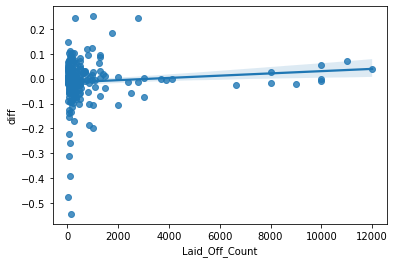

In [15]:
import seaborn as sns
sns.regplot(x="Laid_Off_Count", y="diff", data=new)

In [16]:
from statsmodels.formula.api import ols as sm_ols
from statsmodels.iolib.summary2 import summary_col # nicer tables

reg1 = sm_ols('diff~Laid_Off_Count', data=new).fit()
reg1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   diff   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.336
Date:                Mon, 01 May 2023   Prob (F-statistic):              0.128
Time:                        11:35:35   Log-Likelihood:                 254.01
No. Observations:                 242   AIC:                            -504.0
Df Residuals:                     240   BIC:                            -497.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0151      0.006     -2.548      0.011      -0.027      -0.003
Laid_Off_Count  4.534e-06   2.97e-06      1.528      0.128   -1.31e-06    1.04e-05
==============================================================================
Omnibus:                      135.739   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1441.320
Skew:                          -1.973   Prob(JB):                         0.00
Kurtosis:                      14.286   Cond. No.                     2.16e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:xlabel='l_Laid_Off_Count', ylabel='diff'>

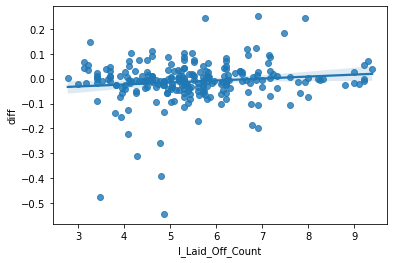

In [17]:
import seaborn as sns
sns.regplot(x="l_Laid_Off_Count", y="diff", data=new)

In [18]:
from statsmodels.formula.api import ols as sm_ols
from statsmodels.iolib.summary2 import summary_col # nicer tables

reg1 = sm_ols('diff~l_Laid_Off_Count', data=new).fit()
reg1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   diff   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     3.989
Date:                Mon, 01 May 2023   Prob (F-statistic):             0.0469
Time:                        11:35:35   Log-Likelihood:                 254.83
No. Observations:                 242   AIC:                            -505.7
Df Residuals:                     240   BIC:                            -498.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0550      0.022     -2.455      0.015      -0.099      -0.011
l_Laid_Off_Count     0.0079      0.004      1.997      0.047       0.000       0.016
==============================================================================
Omnibus:                      133.339   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1328.379
Skew:                          -1.952   Prob(JB):                    3.52e-289
Kurtosis:                      13.794   Cond. No.                         23.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='Percentage', ylabel='diff'>

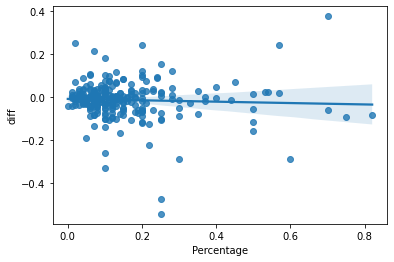

In [19]:
import seaborn as sns
sns.regplot(x="Percentage", y="diff", data=new)

In [20]:
regk= sm_ols('diff~Percentage', data=new).fit()
regk.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   diff   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5932
Date:                Mon, 01 May 2023   Prob (F-statistic):              0.442
Time:                        11:35:36   Log-Likelihood:                 249.88
No. Observations:                 252   AIC:                            -495.8
Df Residuals:                     250   BIC:                            -488.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0079      0.008     -0.935      0.351      -0.025       0.009
Percentage    -0.0321      0.042     -0.770      0.442      -0.114       0.050
==============================================================================
Omnibus:                       89.432   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              963.328
Skew:                          -1.061   Prob(JB):                    6.55e-210
Kurtosis:                      12.340   Cond. No.                         7.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
from pathlib import Path  
filepath = Path('finaldata.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
new.to_csv(filepath)  